# 11. Logistic Regression

This chapter will build on the last and continue with regression in R. In this chapter, we will cover binary logistic regression using the `glm()` function, which can be used to fit generalized linear models. Many of the functions learned in the last chapter can also be used with a `glm` object. For example, the `glm()` function expects a formula in the same way as the `lm()` function. We will also cover diagnostic plots and model evaluation specific to a binary outcome. 

The data used in this chapter is from the 2021 National Youth Tobacco Survey (NYTS). This dataset contains 20,413 participants and a set of variables relating to demographic information, frequency of tobacco use, and methods of obtaining said tobacco as reported by students on the 2021 NYTS. We will use logistic regression to examine whether survey setting was associated with youth reporting of current tobacco use similar to the analysis presented in [Park-Lee et al. (2023). Impact of Survey Setting on Current Tobacco Product Use: National Youth Tobacco Survey, 2021. Journal of Adolescent Health, 72(3), 365-374](https://pubmed.ncbi.nlm.nih.gov/36470692/). Note that we ignore survey weights for this analysis. 

We will use the `broom` package again to present the estimated coefficients, the `tidyverse` package to demonstrate calibration plots, and the `pROC` package to create receiver operating characteristic curves. 

In [1]:
library(broom)
library(tidyverse)
library(pROC)
library(RforHDSdata)
data(nyts)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




## Generalized Linear Models in R

The `glm(formula, data, family)` function in R is used to fit generalized linear models. The three main arguments we must specify to the function are the
* `formula` - specifies the relationship between the independent variables and the outcome of interest,
* `data` - the dataset used to train the model, and 
* `family` - a description of the error distribution and link function to be used in the model. 

In binary logistic regression, we assume a binomial outcome and use the logit link function. We can specify this by setting `family = bimnomial`. By default, this will assume the link function is the logit function. We can even use the `glm()` function to implement linear regression by setting `family = gaussian`. 

TODO: should I add assumptions and form again?

Our outcome of interest will be current e-cigarette use, `e_cig_use`. We need to create this variable from the variables currently in the data. We set `e_cig_use` to 0 if the respondent answered that they have not used e-cigarettes in the last 30 days and 1 otherwise. We can see that there are only 1,435 respondents who reported e-cigarette use. This is a low percentage of overall population and will likely impact our results. 

In [2]:
nyts$e_cig_use <- as.factor(ifelse(nyts$num_e_cigs==0, "0", "1"))
table(nyts$e_cig_use)


    0     1 
18683  1435 

Looking at the covariate of interest, survey setting, we can see that there are 85 respondents that took the survey in "Some other place". We will simplify this variable to have two levels: "school" and "home/other". 

In [3]:
table(nyts$location)
nyts$location <- as.factor(ifelse(nyts$location == "In a school building/classroom", "school", "home/other"))


    At home (virtual learning) In a school building/classroom 
                          8738                          10737 
              Some other place 
                            85 

To start, we will create a model to predict e-cigarette use from school setting and identified covariates sex, school level, and race and ethnicity. We use the `summary()` function again to get a summary of this model. The output has slightly changed. Now, we see the null and residual deviances are reported along with the AIC. Adding transformations and interactions is equivalent to in the `lm()` function and is not demonstrated in this chapter.

In [4]:
mod_start <- glm(e_cig_use ~ grade + sex + race_and_ethnicity + location, data = nyts, family = binomial)
summary(mod_start)


Call:
glm(formula = e_cig_use ~ grade + sex + race_and_ethnicity + 
    location, family = binomial, data = nyts)

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                               -4.60174    0.15388 -29.905  < 2e-16
grade7th                                   0.44606    0.17532   2.544 0.010951
grade8th                                   0.96768    0.16071   6.021 1.73e-09
grade9th                                   1.38300    0.15494   8.926  < 2e-16
grade10th                                  1.91832    0.15132  12.677  < 2e-16
grade11th                                  2.13852    0.14913  14.340  < 2e-16
grade12th                                  2.42858    0.14916  16.282  < 2e-16
gradeUngraded or Other Grade               2.52132    0.44875   5.619 1.93e-08
sexFemale                                  0.19221    0.05795   3.316 0.000912
race_and_ethnicitynon-Hispanic Black      -0.66139    0.11209  -5.900 3.63e-09
r

We can use the `tidy()` function from the broom package to display the estimated coefficients. This time we add the `exponentiate = TRUE` argument to exponentiate our coefficients so we can interpret them as change in odds rather than log odds. For example, those who answered at school had double the estimated odds of reporting e-cigarette use compared to those who took the survey at home/other, adjusting for grade, sex, and race and ethnicity. 

In [5]:
tidy(mod_start, exponentiate=TRUE)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.01003438,0.15387671,-29.9053614,1.676009e-196
grade7th,1.56214571,0.17532017,2.5442613,1.095091e-02
grade8th,2.63183465,0.16071349,6.0211574,1.731743e-09
grade9th,3.98684862,0.15493973,8.9260584,4.414575e-19
grade10th,6.80953207,0.15132448,12.6768878,7.942319e-37
grade11th,8.48684826,0.14913207,14.3397574,1.234864e-46
grade12th,11.34276395,0.14915563,16.2821876,1.320624e-59
gradeUngraded or Other Grade,12.44503967,0.44874868,5.6185616,1.925538e-08
sexFemale,1.21192205,0.05795494,3.3165000,9.115260e-04


## Residuals, Discrimination, and Calibration

Next we look at the distribution of the residuals. The `resid()` function can be used to find the residuals again, but this time we might want to specify the Pearson and deviance residuals by specifying the `type` argument. We plot the histogram for both of these residual types below. In both plots, we can observe a multi-modal distribution, which reflects the binary nature of our outcome. 

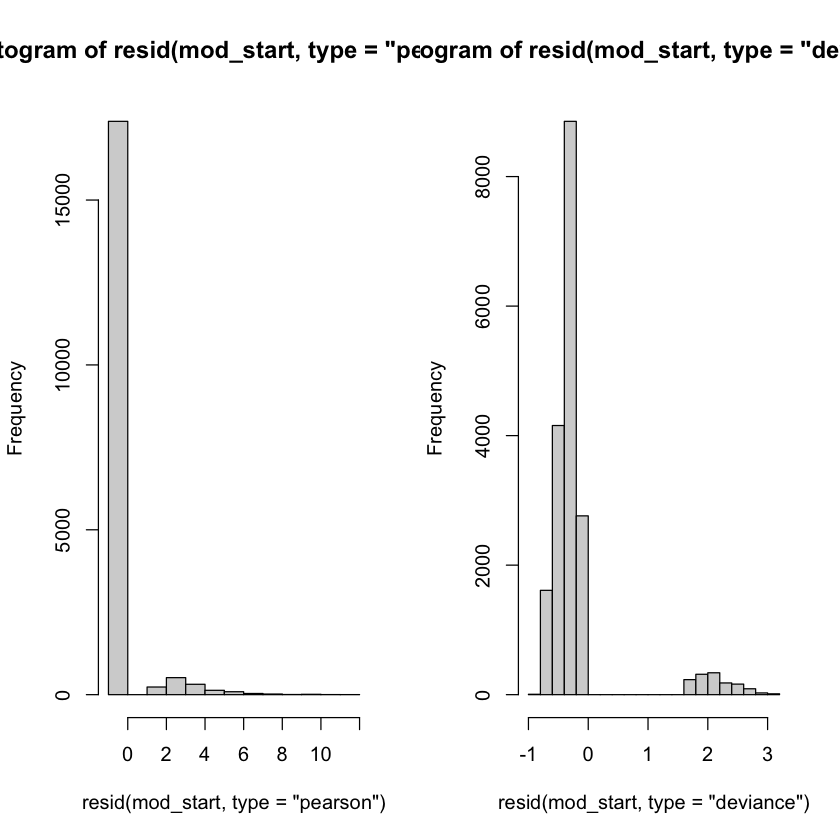

In [6]:
par(mfrow=c(1,2))
hist(resid(mod_start, type="pearson"))
hist(resid(mod_start, type="deviance"))

To further evaluate the fit of our model, we may want to observe the predicted probabilities. The `predict()` function by default will return the predicted value on the scale of the linear predictors. In this case, that is the predicted log odds. If want to find the predicted probabilities, we can update the argument `type="response"`. Additionally, we can predict on data not used to train the model by using the argument `newdata`. Note that there are only 18,747 predicted probabilities despite our training data having more observations. This is because the `glm()` function (and `lm()` function) drop any observations with NA values when training. 

In [7]:
pred_probs <- predict(mod_start, type="response")
length(pred_probs)

[1] 18747

If want to find the class for each observation used in training, we can use the model's output, which stores the model matrix `x` and the outcome vector `y`. We plot the distribution of estimated probabilities for each class. Note that all the predicted probabilities are below 0.5, the typical cut-off for prediction. This is in part due to the fact that we have such an imbalanced outcome. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


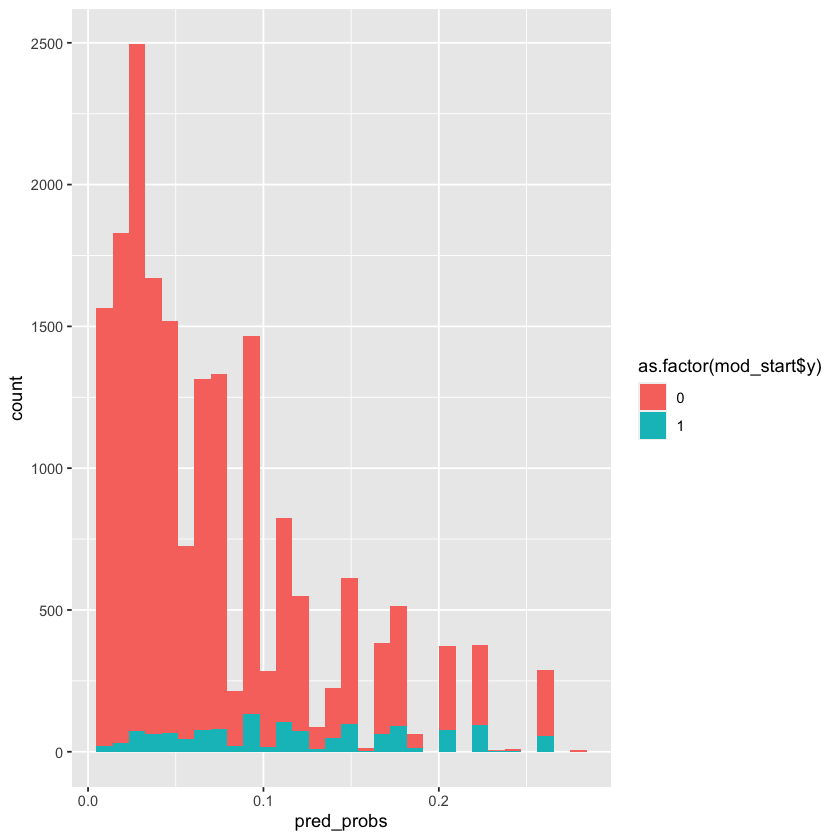

In [8]:
ggplot() + geom_histogram(aes(x=pred_probs, fill=as.factor(mod_start$y)))

We now plot the receiver operating characteristic (ROC) curve and to compute the area under the curve (AUC). The `roc()` function from the `pROC` package builds an ROC curve. The function has several ways to specify a response and predictor. For example, we can specify the response vector `response` and predictor vector `predictor`. By default, with a 0/1 outcome, the `roc()` function will assume class 0 is controls and class 1 is cases. We can also specify this in the `levels` argument to specify the value of the response for controls and cases, respectively. Additionally, the function assumes the predictor vector specifies predicted probabilities for the class 1. We can change the argument `direction = >` if the opposite is true. We can plot the ROC curve by calling the `plot()` function. We can add some extra information by adding the AUC (`print.auc = TRUE`) and the threshold that maximizes sensitivity + specificity (`print.thres = TRUE`). 

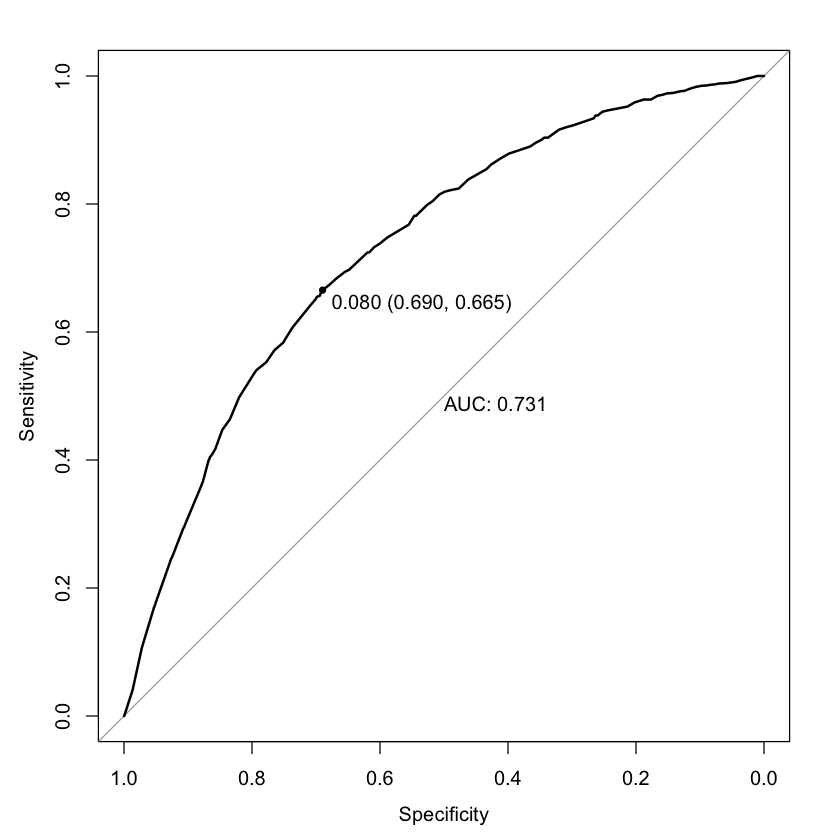

In [9]:
roc_mod <- roc(predictor=pred_probs, response=as.factor(mod_start$y), levels = c(0,1), direction = "<")
plot(roc_mod, print.auc=TRUE, print.thres = TRUE)

If we want to understand more about the curve, we can use the `coords()` function to find the coordinates for each threshold used. The argument `x= "all"` specifies we want to find all thresholds but we could also specify only to return local maxima. 

In [10]:
roc_vals <- coords(roc=roc_mod, x = "all")
head(roc_vals)

,threshold,specificity,sensitivity
,<dbl>,<dbl>,<dbl>
1,-Inf,0.000000000,1.0000000
2,0.005694962,0.005233795,1.0000000
3,0.007131542,0.010697648,1.0000000
4,0.008502529,0.015471329,0.9985294
5,0.009344669,0.018347041,0.9977941
6,0.009822271,0.024040950,0.9963235


We could use this information to find the threshold for sensitivity to be above 0.75. A threshold of 0.062 is the highest threshold with sensitivity above 0.75 and sensitivity 0.55. 

In [11]:
roc_vals[roc_vals$sensitivity > 0.75, ] %>% tail(n=1)

,threshold,specificity,sensitivity
,<dbl>,<dbl>,<dbl>
63,0.06201043,0.5551274,0.7676471


We will use the threshold of 0.080 indicates on our ROC curve to create predicted classes for our response. By comparing to our outcome using the `table()` function, we can directly calculate the sensitivity, specificity, and overall accuracy.

In [12]:
pred_ys <- ifelse(pred_probs > 0.08, 1, 0)
tab_outcome <- table(mod_start$y, pred_ys)
tab_outcome

   pred_ys
        0     1
  0 11992  5395
  1   455   905

In [13]:
sens <- tab_outcome[2,2]/(tab_outcome[2,1]+tab_outcome[2,2])
round(sens, 3)

[1] 0.665

In [14]:
spec <- tab_outcome[1,1]/(tab_outcome[1,1]+tab_outcome[1,2])
spec

[1] 0.6897107

In [15]:
acc <- (tab_outcome[1,1]+tab_outcome[2,2])/sum(tab_outcome)
acc

[1] 0.6879501

Another useful plot is a calibration plot. This type of plot groups the data by the estimated probabilities and compares the mean probability with the observed percentage of observations in class 1. In a sense, it visualizes how close our estimated distribution and true distribution are to each other. There are several packages that can create calibration plots, but we demonstrate how to do this using the tidyverse packages. First, we create a data frame with the predicted probabilities and outcome. Additionally, we group this data into `num_cuts` groups based on the predicted probabilities. Then, we find the estimated mean and standard error within each group along with the observed proportion. 

In [16]:
num_cuts <- 10
calib_data <-  data.frame(prob = pred_probs,
                          bin = cut(pred_probs, breaks = num_cuts),
                          class = mod_start$y)
calib_data <- calib_data %>% 
             group_by(bin) %>% 
             summarize(observed = sum(class)/n(), expected = sum(prob)/n(), se = sqrt(expected*(1-expected)/n()))
head(calib_data)

bin,observed,expected,se
<fct>,<dbl>,<dbl>,<dbl>
"(0.00488,0.0322]",0.02123323,0.02028734,0.001837447
"(0.0322,0.0592]",0.04397852,0.04411129,0.003283482
"(0.0592,0.0862]",0.06212914,0.07079371,0.004791716
"(0.0862,0.113]",0.09860248,0.09884938,0.005880479
"(0.113,0.14]",0.13122172,0.12331957,0.012769676
"(0.14,0.167]",0.17391304,0.14635393,0.012283608


Next, we plot the observed vs expected proportions along with error bars. The red line indicates a perfect fit. 

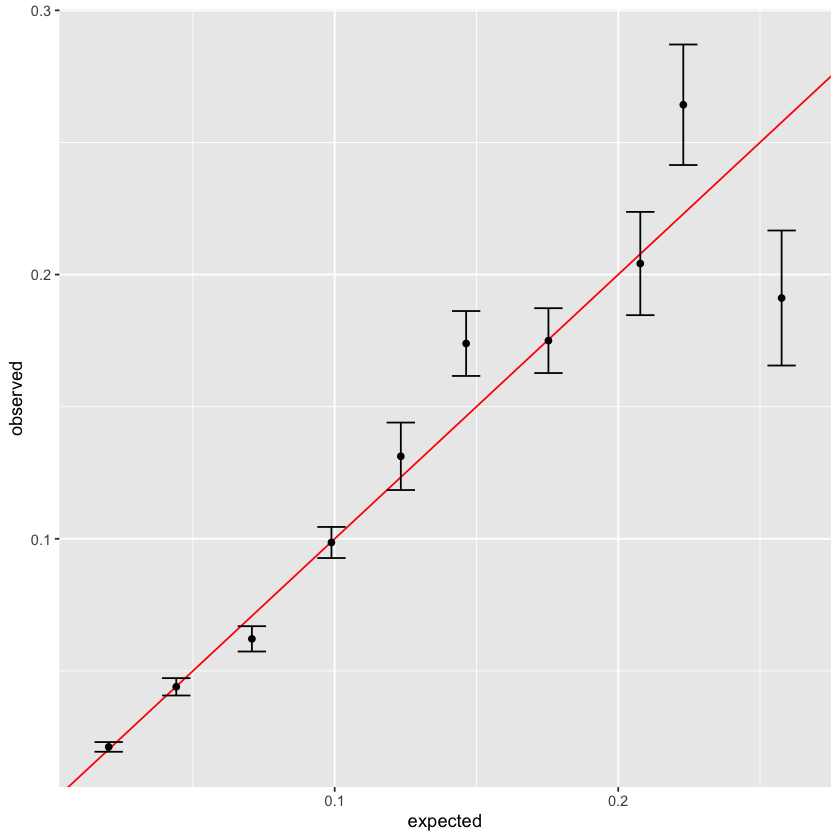

In [17]:
ggplot(calib_data) + 
  geom_abline(intercept = 0, slope = 1, color="red") + 
  geom_errorbar(aes(x = expected, ymin=observed-se, ymax=observed+se), colour="black", width=.01)+
  geom_point(aes(x = expected, y = observed))

## Variable Selection

In the last chapter, we introduced the `step()` function to implement stepwise variable selection. This function also works with `glm` objects. In this case, we use this function to implement backward selection from a larger set of covariates. We first remove any observations with NA values to ensure that our training data does not change size as the formula changes. 

In [18]:
nyts_sub <- nyts %>% 
  dplyr::select(location, sex, grade, otherlang, grades_in_past_year, perceived_e_cig_use, 
                            race_and_ethnicity, LGBT, psych_distress, family_affluence, e_cig_use) %>%
  na.omit()
head(nyts_sub)

location,sex,grade,otherlang,grades_in_past_year,perceived_e_cig_use,race_and_ethnicity,LGBT,psych_distress,family_affluence,e_cig_use
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>
school,Male,6th,No,Mostly A's,0,non-Hispanic White,No,mild,medium,0
school,Female,6th,No,Mostly A's,0,non-Hispanic White,Not Sure,none,high,0
school,Female,6th,No,Mostly C's,0,non-Hispanic Black,Yes,severe,medium,0
school,Female,6th,No,Mostly A's,0,non-Hispanic White,No,none,high,0
school,Female,6th,No,Mostly B's,0,Hispanic,No,none,high,0
school,Male,6th,No,Not Sure,0,non-Hispanic White,No,mild,medium,0


To implement backward selection, we first create a model with all the covariates included. The period `.` in the formula indicates to include all variables. Next, we use the `step()` function. Since we are using backward selection, we only need to specify the lower formula in the scope. 

In [19]:
model_full <- glm(e_cig_use ~ ., data = nyts_sub, family = binomial)
mod_step <- step(model_full, direction = 'backward', 
                 scope = list(lower = "e_cig_use ~ sex + grade + race_and_ethnicity + location"))

Start:  AIC=6093.41
e_cig_use ~ location + sex + grade + otherlang + grades_in_past_year + 
    perceived_e_cig_use + race_and_ethnicity + LGBT + psych_distress + 
    family_affluence

                      Df Deviance    AIC
- family_affluence     2   6038.0 6090.0
<none>                     6037.4 6093.4
- otherlang            1   6042.5 6096.5
- LGBT                 2   6051.4 6103.4
- psych_distress       3   6105.5 6155.5
- grades_in_past_year  6   6126.2 6170.2
- perceived_e_cig_use  1   6415.5 6469.5

Step:  AIC=6090
e_cig_use ~ location + sex + grade + otherlang + grades_in_past_year + 
    perceived_e_cig_use + race_and_ethnicity + LGBT + psych_distress

                      Df Deviance    AIC
<none>                     6038.0 6090.0
- otherlang            1   6043.0 6093.0
- LGBT                 2   6051.7 6099.7
- psych_distress       3   6105.6 6151.6
- grades_in_past_year  6   6128.0 6168.0
- perceived_e_cig_use  1   6418.4 6468.4


Stepwise selection keeps most variables in the model and only drops family affluence. We can see the AUC for this model has improved to 0.818.

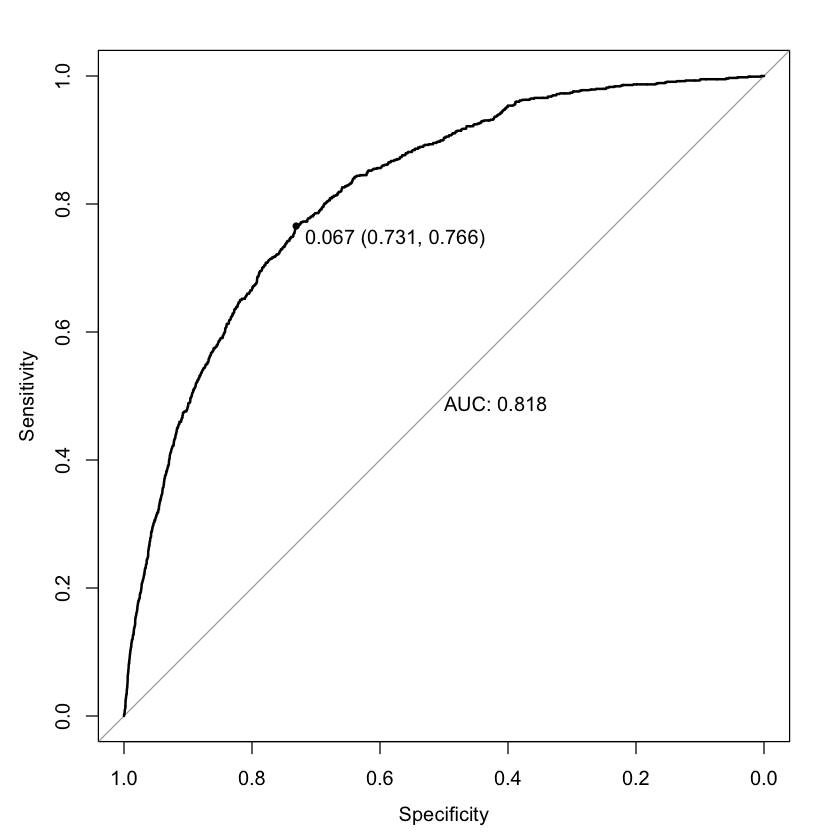

In [20]:
roc_mod_step <- roc(predictor=predict(mod_step, type="response"), response=as.factor(mod_step$y), 
                    levels = c(0,1), direction = "<")
plot(roc_mod_step, print.auc=TRUE, print.thres = TRUE)

## Exercises:

1. Try using `lm` for analyzing the smoking behavior as a function of variables in the `nyts` data. They can be random from your favorite or interested potential predictors. Fit a Logistic regression to your subset of data frame using `glm`. Are the estimated coefficients similar to the true ones we used?

2. What is the estimated probability of an event at x=1,1? Use `predict()` function but make sure to read the documentation on the type argument.

3. Measure accuracy and precision of your model.